# Results Analysis

In [1]:
import sys
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

sys.path.append("..")
from src.tools import DataPipeline
from src.inference import Inference

# Setting to show more columns
pd.set_option("display.max_columns", 30)

- Lets use the test dataset to perform an analysis

In [2]:
# Load dataset
data_dir = '../data/turbofan.csv'
dpl = DataPipeline()
dpl.ingest_data(data_dir)
_, X_test, _, y_test = dpl.fit_transform(alpha=0.3,sequence_length=100)

print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X_test: (1995, 100, 15)
y_test: (1995,)


In [3]:
# Load Model
model_weights_path = '../weights/lstm.h5'
inf = Inference()
model = inf.load_model(model_weights_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 32)           6144      
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 31,041
Trainable params: 31,041
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Predict the test input features
predictions = model.predict(X_test).flatten()
comparison_df = pd.DataFrame({'predictions':predictions,
                              'actual':y_test})
comparison_df.head()

,predictions,actual
0,109.524284,169.0
1,109.628578,168.0
2,109.671333,167.0
3,109.713493,166.0
4,109.726860,165.0


- Now we can perform an analysis of the results by turning it into a binary classification problem.

In [5]:
comparison_df['predictions_bool'] = comparison_df.predictions.apply(lambda x: x<15)
comparison_df['actual_bool'] = comparison_df.actual.apply(lambda x: x<15)
comparison_df.head()

,predictions,actual,predictions_bool,actual_bool
0,109.524284,169.0,False,False
1,109.628578,168.0,False,False
2,109.671333,167.0,False,False
3,109.713493,166.0,False,False
4,109.726860,165.0,False,False


In [6]:
s = comparison_df.groupby(['actual'])[['predictions_bool','actual_bool']].apply(lambda x: ([list(x['predictions_bool']),list(x['actual_bool'])]))
s.head()

actual
0.0    [[True, True, True, True, True, True, True, Tr...
1.0    [[True, True, True, True, True, True, True, Tr...
2.0    [[True, True, True, True, True, True, True, Tr...
3.0    [[True, True, True, True, True, True, True, Tr...
4.0    [[True, True, True, True, True, True, True, Tr...
dtype: object

In [7]:
results_per_RC = pd.DataFrame({'RC':s.index.astype(int),
                               'accuracy_score':s.apply(lambda x: accuracy_score(x[1],x[0])).values})
results_per_RC['detect_failure'] = results_per_RC.apply(lambda x: x[1] if x[0]<15 else 1-x[1], axis=1)
results_per_RC[5:26].transpose()

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
RC,5.00,6.0,7.00,8.00,9.00,10.0,11.0,12.00,13.00,14.00,15.00,16.0,17.00,18.0,19.0,20.0,21.00,22.00,23.00,24.00,25.00
accuracy_score,0.95,0.9,0.75,0.75,0.65,0.6,0.5,0.35,0.35,0.25,0.75,0.8,0.85,0.9,0.9,0.9,0.95,0.95,0.95,0.95,0.95
detect_failure,0.95,0.9,0.75,0.75,0.65,0.6,0.5,0.35,0.35,0.25,0.25,0.2,0.15,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.05


- We will use this data to plot a graph, we can study the probability of predicting a failure near to where it is important.

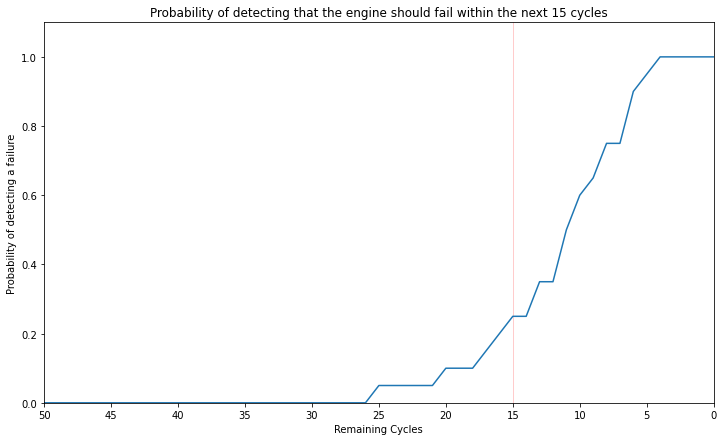

In [8]:
plt.figure(figsize=(12,7))
sns.lineplot(data=results_per_RC,x='RC',y='detect_failure')
sns.lineplot(x=[15,15],y=[0,1.1],color='red')
plt.title('Probability of detecting that the engine should fail within the next 15 cycles')
plt.xlabel('Remaining Cycles')
plt.ylabel('Probability of detecting a failure')
plt.xticks(list(range(0,51,5)))
plt.axis([50,0,0,1.1])
plt.show()

- As it can be shown, the probability of detecting an early failure is low. This means that there is a chance that when an engine may fail earlier than 15 days when detected.
- To overcome this, one may add a buffer to the predicted remaning cycles. ie (predict that engine will fail in 15 days even though the predicted remaining cycles is 23)
- Lets test this.

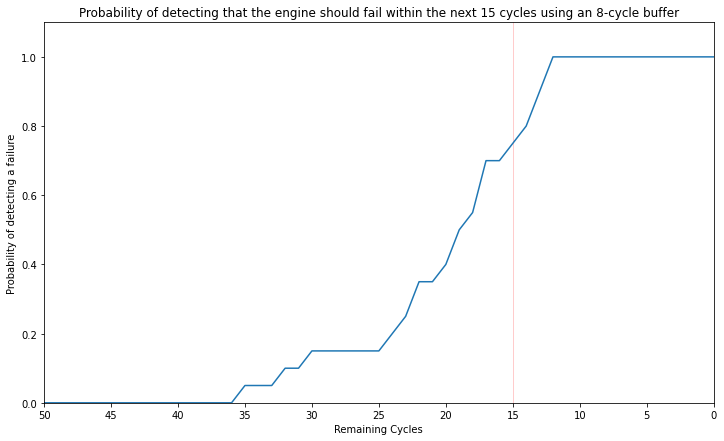

In [9]:
comparison_df['predictions_bool'] = comparison_df.predictions.apply(lambda x: x<23)
comparison_df['actual_bool'] = comparison_df.actual.apply(lambda x: x<15)
s = comparison_df.groupby(['actual'])[['predictions_bool','actual_bool']].apply(lambda x: ([list(x['predictions_bool']),list(x['actual_bool'])]))
results_per_RC = pd.DataFrame({'RC':s.index.astype(int),
                               'accuracy_score':s.apply(lambda x: accuracy_score(x[1],x[0])).values})
results_per_RC['detect_failure'] = results_per_RC.apply(lambda x: x[1] if x[0]<15 else 1-x[1], axis=1)
plt.figure(figsize=(12,7))
sns.lineplot(data=results_per_RC,x='RC',y='detect_failure')
sns.lineplot(x=[15,15],y=[0,1.1],color='red')
plt.title('Probability of detecting that the engine should fail within the next 15 cycles using an 8-cycle buffer')
plt.xlabel('Remaining Cycles')
plt.ylabel('Probability of detecting a failure')
plt.xticks(list(range(0,51,5)))
plt.axis([50,0,0,1.1])
plt.show()

- Using an 8 day buffer, there is much lower probability that there will be a late detection of engine failure within 15 cycles. This may be of more use to the client.
- The setback here is that there is also a chance to predict that an engine will fail in 15 cycles, even though it may have as much as 30 cycles remaining.
- The client can decide how best to use this model
- Next we will show the cumulative probability of the same chart, using a 4-cycle buffer instead.

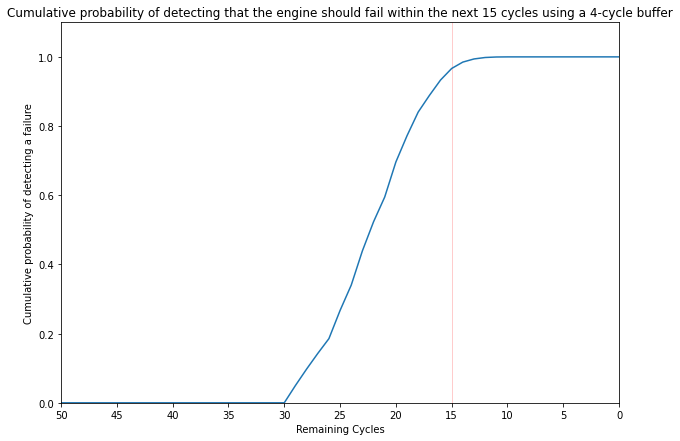

In [33]:
comparison_df['predictions_bool'] = comparison_df.predictions.apply(lambda x: x<19)
comparison_df['actual_bool'] = comparison_df.actual.apply(lambda x: x<15)
s = comparison_df.groupby(['actual'])[['predictions_bool','actual_bool']].apply(lambda x: ([list(x['predictions_bool']),list(x['actual_bool'])]))
results_per_RC = pd.DataFrame({'RC':s.index.astype(int),
                               'accuracy_score':s.apply(lambda x: accuracy_score(x[1],x[0])).values})
results_per_RC['detect_failure'] = results_per_RC.apply(lambda x: x[1] if x[0]<15 else 1-x[1], axis=1)

# Calculate the cumulative probability of detecting engine failure
results_per_RC['cum_detection_probability']=(1-(1-results_per_RC.detect_failure).iloc[::-1].cumprod().iloc[::-1])

plt.figure(figsize=(10,7))
sns.lineplot(data=results_per_RC,x='RC',y='cum_detection_probability')
sns.lineplot(x=[15,15],y=[0,1.1],color='red')
plt.title('Cumulative probability of detecting that the engine should fail within the next 15 cycles using a 4-cycle buffer')
plt.xlabel('Remaining Cycles')
plt.ylabel('Cumulative probability of detecting a failure')
plt.xticks(list(range(0,51,5)))
plt.axis([50,0,0,1.1])
plt.show()

In [30]:
results_per_RC[results_per_RC.RC==15]

,RC,accuracy_score,detect_failure,cum_detection_probability
15,15,0.5,0.5,0.966498


- As shown above, a 4 day buffer is enough to give a 96% confidence to detect an engine failure occurence within the next 15 days.